In [1]:
from shapely.geometry import LineString, Polygon, Point, MultiPoint
import pandas as pd
from pathlib import Path
import seaborn as sns
from pprint import pprint
import random
import numpy as np
from itertools import combinations, count, chain
import matplotlib.pyplot as plt
from functools import lru_cache
import geopandas as gpd
from shapely.affinity import affine_transform, scale

/home/nialov/.local/share/virtualenvs/trace_repo-280iuCPs/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
import fractopo_subsampling.utils as utils

In [3]:
boldstyle = dict(fontsize=14)


def pcircle(point, radius):
    return point.buffer(radius)


def row_y(vals, sim_row_y):
    return tuple((val[0], val[1] + sim_row_y) for val in vals)


def circle_srs(coords, radii):
    return gpd.GeoSeries(
        [pcircle(Point(x, y), rad) for (x, y), rad in zip(coords, radii)]
    )


def backround_circles(base_coords, base_radii, sim_row_y):
    background_base = circle_srs(row_y(base_coords, sim_row_y=sim_row_y), base_radii)
    return background_base


def boundary_plot(ax, circles):
    assert all(isinstance(geom, Polygon) for geom in circles.geometry.values)
    circles.boundary.loc[
        [not geom.is_empty for geom in circles.boundary.geometry.values]
    ].plot(ax=ax, color="black")
    return ax


def backround_plot(ax, circles):
    circles.plot(ax=ax, alpha=0.1, color="black")
    return ax


def area_coords(coords, row_y, base_y):
    return tuple((coord[0], coord[1] + row_y + base_y) for coord in coords)


def boldtext(ax, x, y, s):
    ax.text(x, y, s, rotation=90, va="center", **boldstyle)

In [4]:
all_traces, all_areas, all_area_radii = [], [], []
for trace_path, area_path in zip(
    [
        "/mnt/f/Users/nikke/Documents/projects/Academic_projects/gtk_ahvenanmaa/sampling_simulation/data/simulation_diagram_traces_1.gpkg",
        "/mnt/f/Users/nikke/Documents/projects/Academic_projects/gtk_ahvenanmaa/sampling_simulation/data/simulation_diagram_traces_2.gpkg",
        "/mnt/f/Users/nikke/Documents/projects/Academic_projects/gtk_ahvenanmaa/sampling_simulation/data/simulation_diagram_traces_3.gpkg",
    ],
    [
        "/mnt/f/Users/nikke/Documents/projects/Academic_projects/gtk_ahvenanmaa/sampling_simulation/data/simulation_diagram_area_1.gpkg",
        "/mnt/f/Users/nikke/Documents/projects/Academic_projects/gtk_ahvenanmaa/sampling_simulation/data/simulation_diagram_area_2.gpkg",
        "/mnt/f/Users/nikke/Documents/projects/Academic_projects/gtk_ahvenanmaa/sampling_simulation/data/simulation_diagram_area_3.gpkg",
    ],
):
    traces, area_poly = gpd.read_file(trace_path), gpd.read_file(area_path)
    area_poly_radius = sum(np.sqrt(area_poly.area / np.pi)) - 1.2
    all_traces.append(traces)
    all_area_radii.append(area_poly_radius)

In [5]:
def transform_to_xy(x, y, geoms, area_poly_radius):
    geoms = geoms.copy()
    center = MultiPoint([p for p in geoms.representative_point()]).centroid
    affine_matrix = [1, 0, 0, 1, -center.x + x, -center.y + y]
    center_af = affine_transform(center, matrix=affine_matrix)
    factor = 25 / area_poly_radius
    geoms_transformed = geoms.affine_transform(affine_matrix).scale(
        xfact=factor, yfact=factor, origin=center_af
    )
    return geoms_transformed

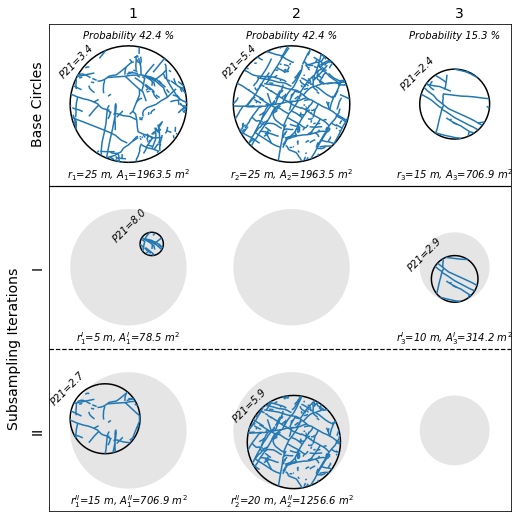

In [6]:
fig, ax = plt.subplots(figsize=utils.paper_figsize(0.5))
base_circle_radii = 25, 25, 15
base_circle_areas = [np.pi * rad ** 2 for rad in base_circle_radii]
base_circle_coords = (0, 0), (70, 0), (140, 0)
base_circles = circle_srs(base_circle_coords, base_circle_radii)
ax = boundary_plot(ax=ax, circles=base_circles)
ax.tick_params(
    which="both",
    axis="both",
    bottom=False,
    top=False,
    left=False,
    labelleft=False,
    labelbottom=False,
)

# Sim 1

sim_1_row_y = -70
sim_1_circle_radii = 5, 0, 10
sim_1_circle_coords = row_y(((10, 10), (70, 0), (140, -5)), sim_row_y=sim_1_row_y)
sim_1_circles = circle_srs(sim_1_circle_coords, sim_1_circle_radii)
background_base_1 = backround_circles(
    base_circle_coords, base_circle_radii, sim_1_row_y
)
ax = backround_plot(ax=ax, circles=background_base_1)
ax = boundary_plot(ax=ax, circles=sim_1_circles)
# sim_1_circles.boundary.plot(ax=ax)

# Sim 2

sim_2_row_y = sim_1_row_y * 2
sim_2_circle_radii = 15, 20, 0
sim_2_circle_coords = row_y(((-10, 5), (71, -5), (140, -5)), sim_row_y=sim_2_row_y)
sim_2_circles = circle_srs(sim_2_circle_coords, sim_2_circle_radii)
background_base_2 = backround_circles(
    base_circle_coords, base_circle_radii, sim_2_row_y
)
ax = backround_plot(ax=ax, circles=background_base_2)
ax = boundary_plot(ax=ax, circles=sim_2_circles)

y_negator = count(0, step=sim_1_row_y)

# Traces
for coords, circles, true_coords in zip(
    (base_circle_coords, base_circle_coords, base_circle_coords),
    (base_circles, sim_1_circles, sim_2_circles),
    (base_circle_coords, sim_1_circle_coords, sim_2_circle_coords),
):
    y_minus = next(y_negator)
    for (x, y), circle, traces, area_poly_radius, true_coord in zip(
        coords, circles, all_traces, all_area_radii, true_coords
    ):
        y += y_minus
        assert isinstance(x, (int, float))
        assert isinstance(circle, Polygon)
        assert isinstance(traces, (gpd.GeoSeries, gpd.GeoDataFrame))
        assert isinstance(area_poly_radius, float)
        assert area_poly_radius > 0
        transformed = transform_to_xy(x, y, traces, area_poly_radius)
        if circle.area > 0:
            clipped = gpd.clip(transformed, circle)
            clipped.plot(ax=ax)
            p21 = round(sum(clipped.length) / (circle.area * 0.1), 1)
            true_rad = np.sqrt(circle.area / np.pi) + 10
            true_a = true_rad / np.sqrt((23 / 19) ** 2 + 1)
            ax.text(
                true_coord[0] - true_a,
                true_coord[1] + (true_a * (19 / 23)),
                s=f"P21={p21}",
                rotation=45,
                style="italic",
                ha="center",
                va="center",
            )

# Texts
text_x_base = -42
boldtext(ax, text_x_base, 0, s="Base Circles")
boldtext(ax, text_x_base, sim_1_row_y, s="I")
boldtext(ax, text_x_base, sim_2_row_y, s="II")
boldtext(ax, text_x_base - 10, -105, s="Subsampling Iterations")

all_radii = chain(base_circle_radii, sim_1_circle_radii, sim_2_circle_radii)


# identify iteration or lack of
iteration = {0: None, sim_1_row_y: "I", sim_2_row_y: "II"}
# Areas
y_move = -32
for row_y_val in (0, sim_1_row_y, sim_2_row_y):
    for idx, (x, y) in enumerate(area_coords(base_circle_coords, row_y_val, y_move)):
        idx += 1
        radius = next(all_radii)
        area_val = round(np.pi * radius ** 2, 1)
        identity = lambda var: f"${var}_{idx}" + (
            "$"
            if iteration[row_y_val] is None
            else ("^{" + f"{iteration[row_y_val]}" + "}$")
        )
        area_identity = identity("A")
        rad_identity = identity("r")
        ax.text(
            x,
            y,
            f"{rad_identity}={radius} $m$, {area_identity}={area_val} $m^2$",
            ha="center",
            style="italic",
        ) if area_val > 0 else None
        ax.text(
            x,
            y - y_move + 28,
            f"Probability {round(100 *(area_val / sum(base_circle_areas)), 1)} %",
            ha="center",
            style="italic",
        ) if row_y_val == 0 else None

# IDs for base circles
ider = count(1)
for x, _ in base_circle_coords:
    ax.text(x, 37, s=str(next(ider)), **boldstyle)

# Horizontal lines
ax.axhline(-35, color="black", linestyle="-", linewidth=1.2)
ax.axhline(-105, color="black", linestyle="dashed", linewidth=1.2)

# Final setup
fig.set_size_inches(*utils.paper_figsize(1))
fig.savefig(
    "/mnt/f/Users/nikke/Documents/projects/Academic_projects/gtk_ahvenanmaa/sampling_simulation/visualizations/subsampling_diagram.svg",
    bbox_inches="tight",
)